In [1]:
# 네이버 영화리뷰 감정 분석

import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
# 데이터 준비와 확인
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 데이터로더 구성

# 데이터의 중복 제거
# NaN 결측치 제거
# 한국어 토크나이저로 토큰화
# 불용어(Stopwords) 제거
# 사전word_to_index 구성
# 텍스트 스트링을 사전 인덱스 스트링으로 변환
# X_train, y_train, X_test, y_test, word_to_index 리턴

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '을', '보', '기', '어요', '입니다', '하고']


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]
# '<PAD>'  # 패딩용 단어
# '<BOS>'  # 문장의 시작지점
# '<UNK>'  # 사전에 없는(Unknown) 단어
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word)

{0: '', 1: '<PAD>', 2: '<BOS>', 3: '<UNK>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '..', 10: '게', 11: ',', 12: '!', 13: '지', 14: '있', 15: '없', 16: '?', 17: '좋', 18: '나', 19: '었', 20: '만', 21: '는데', 22: '너무', 23: '봤', 24: '적', 25: '안', 26: '정말', 27: '로', 28: '음', 29: '것', 30: '아', 31: '네요', 32: '재밌', 33: '어', 34: '같', 35: '점', 36: '지만', 37: '진짜', 38: '했', 39: '에서', 40: '네', 41: '않', 42: '거', 43: '았', 44: '수', 45: '되', 46: '면', 47: 'ㅋㅋ', 48: '말', 49: '연기', 50: '인', 51: '주', 52: '내', 53: '최고', 54: '~', 55: '평점', 56: '이런', 57: '던', 58: '할', 59: '왜', 60: '겠', 61: '1', 62: '스토리', 63: '해', 64: '습니다', 65: 'ㅋㅋㅋ', 66: '...', 67: '드라마', 68: '생각', 69: '아니', 70: '더', 71: '그', 72: '싶', 73: '사람', 74: '듯', 75: '때', 76: '감동', 77: '함', 78: '배우', 79: '본', 80: '까지', 81: '뭐', 82: '알', 83: '만들', 84: '내용', 85: '볼', 86: '감독', 87: '보다', 88: '라', 89: '그냥', 90: '재미', 91: '시간', 92: '지루', 93: '중', 94: '재미있', 95: '년', 96: '10', 97: '였', 98: '잼', 99: '사랑', 100: '못', 101: '냐', 102: '재미없', 103: '쓰레기', 104: '서', 1

In [5]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'': 0, '<PAD>': 1, '<BOS>': 2, '<UNK>': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '..': 9, '게': 10, ',': 11, '!': 12, '지': 13, '있': 14, '없': 15, '?': 16, '좋': 17, '나': 18, '었': 19, '만': 20, '는데': 21, '너무': 22, '봤': 23, '적': 24, '안': 25, '정말': 26, '로': 27, '음': 28, '것': 29, '아': 30, '네요': 31, '재밌': 32, '어': 33, '같': 34, '점': 35, '지만': 36, '진짜': 37, '했': 38, '에서': 39, '네': 40, '않': 41, '거': 42, '았': 43, '수': 44, '되': 45, '면': 46, 'ㅋㅋ': 47, '말': 48, '연기': 49, '인': 50, '주': 51, '내': 52, '최고': 53, '~': 54, '평점': 55, '이런': 56, '던': 57, '할': 58, '왜': 59, '겠': 60, '1': 61, '스토리': 62, '해': 63, '습니다': 64, 'ㅋㅋㅋ': 65, '...': 66, '드라마': 67, '생각': 68, '아니': 69, '더': 70, '그': 71, '싶': 72, '사람': 73, '듯': 74, '때': 75, '감동': 76, '함': 77, '배우': 78, '본': 79, '까지': 80, '뭐': 81, '알': 82, '만들': 83, '내용': 84, '볼': 85, '감독': 86, '보다': 87, '라': 88, '그냥': 89, '재미': 90, '시간': 91, '지루': 92, '중': 93, '재미있': 94, '년': 95, '10': 96, '였': 97, '잼': 98, '사랑': 99, '못': 100, '냐': 101, '재미없': 102, '쓰레기': 103, '서': 104, '

In [6]:
# 인덱스 변환시 참고 코딩(이 노트에서는 사용하지 않음)
# # 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# # 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
# def get_encoded_sentence(sentence, word_to_index):
#     return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# # 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
# def get_encoded_sentences(sentences, word_to_index):
#     return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# # 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
# def get_decoded_sentence(encoded_sentence, index_to_word):
#     return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# # 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
# def get_decoded_sentences(encoded_sentences, index_to_word):
#     return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
# 모델 구성을 위한 데이터 분석 및 가공

# 데이터셋 내 문장 길이 분포
# 적절한 최대 문장 길이 지정
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.477682388053589
문장길이 최대 :  116
문장길이 표준편차 :  12.413149810947711
pad_sequences maxlen :  40
전체 문장의 0.9353892463870502%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
# 문장의 앞부분에 패딩 추가 LSTM으로 학습할경우 대비

import numpy as np
import tensorflow as tf
import os


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)


(146182, 40)


# 글로벌 맥스풀링

In [9]:
#딥러닝 모델의 설계와 훈련
#글로벌 맥스풀링


vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [10]:
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 40)
(116182,)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 4ms/step - loss: 0.6264 - accuracy: 0.6986 - val_loss: 0.5122 - val_accuracy: 0.8070
Epoch 2/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4163 - accuracy: 0.8326 - val_loss: 0.3733 - val_accuracy: 0.8387
Epoch 3/20
227/227 [==============================] - 1s 3ms/step - loss: 0.3360 - accuracy: 0.8592 - val_loss: 0.3536 - val_accuracy: 0.8438
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3035 - accuracy: 0.8745 - val_loss: 0.3516 - val_accuracy: 0.8465
Epoch 5/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2812 - accuracy: 0.8855 - val_loss: 0.3551 - val_accuracy: 0.8482
Epoch 6/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2633 - accuracy: 0.8941 - val_loss: 0.3613 - val_accuracy: 0.8474
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2479 - accuracy: 0.9013 - val_loss: 0.3701 - val_accuracy: 0.8455
Epoch 

In [12]:
#epoch 8 이후 과적합 경향
#테스트 평가

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5414 - accuracy: 0.8252
[0.5414133071899414, 0.8252130746841431]


In [13]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


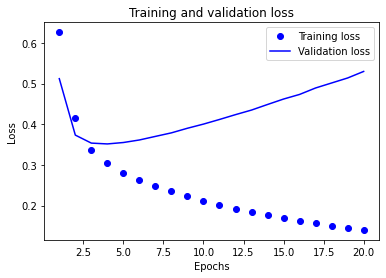

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# epoch 약 6회부터 과적합이 되는 것으로 보임 loss값이 올라간다.


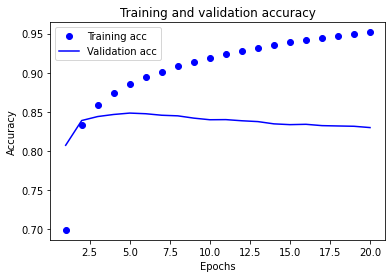

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# epoch 약 6회부터 과적합이 되는 것으로 보임  accuracy 소폭 감소 

In [18]:
# 임베딩 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [19]:
# 자체 학습한 Embedding 파라미터를 파일에 써서 저장합니다. word2vec
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(3,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# gensim으로 유사도 찾기

In [20]:
# gensim으로 유사도 찾기

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.16901338,  0.06376065, -0.20290713, -0.02415236, -0.24656755,
       -0.21688794, -0.12632799, -0.01751253, -0.2556701 , -0.28042552,
       -0.24790697,  0.07824137, -0.25559446,  0.14367707,  0.10118979,
        0.01508263], dtype=float32)

In [21]:
word_vectors.similar_by_word("사랑")

[('재대로', 0.8700941205024719),
 ('이종혁', 0.8629039525985718),
 ('옹', 0.853559136390686),
 ('봅니다', 0.81761634349823),
 ('!!!!!!!!!!', 0.8173024654388428),
 ('무언가', 0.8164659142494202),
 ('백', 0.8127192854881287),
 ('꾼', 0.812119722366333),
 ('아기', 0.8090218305587769),
 (',,', 0.7939661145210266)]

In [22]:
# 한국어 Word2Vec 임베딩 활용하여 성능 개선

from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path2 = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path2)
vector = word_vectors.wv['사랑']

In [23]:
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [24]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [25]:
# 좀더 비슷한 감정의 단어들이 선택 되었다.

# RNN

In [26]:
# 다른 모델로 학습해보기
# RNN

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 8ms/step - loss: 0.5104 - accuracy: 0.7670 - val_loss: 0.3728 - val_accuracy: 0.8422
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3462 - accuracy: 0.8539 - val_loss: 0.3521 - val_accuracy: 0.8481
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3202 - accuracy: 0.8669 - val_loss: 0.3492 - val_accuracy: 0.8504
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3075 - accuracy: 0.8726 - val_loss: 0.3484 - val_accuracy: 0.8491
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2976 - accuracy: 0.8782 - val_loss: 0.3593 - val_accuracy: 0.8481
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2891 - accuracy: 0.8817 - val_loss: 0.3579 - val_accuracy: 0.8497
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2807 - accuracy: 0.8866 - val_loss: 0.3682 - val_accuracy: 0.8478
Epoch 

In [28]:
#테스트 평가

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4554 - accuracy: 0.8349
[0.45542821288108826, 0.8349370360374451]


# CNN

In [29]:
# CNN 모델로 설계 및 학습

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
#학습 및 테스트 평가

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/10
227/227 [==============================] - 3s 6ms/step - loss: 0.5581 - accuracy: 0.7044 - val_loss: 0.4406 - val_accuracy: 0.7874
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.4084 - accuracy: 0.8072 - val_loss: 0.4262 - val_accuracy: 0.7950
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3718 - accuracy: 0.8273 - val_loss: 0.4301 - val_accuracy: 0.7948
Epoch 4/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3426 - accuracy: 0.8438 - val_loss: 0.4379 - val_accuracy: 0.7909
Epoch 5/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3141 - accuracy: 0.8592 - val_loss: 0.4521 - val_accuracy: 0.7913
Epoch 6/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2858 - accuracy: 0.8735 - val_loss: 0.4746 - val_accuracy: 0.7874
Epoch 7/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2587 - accuracy: 0.8865 - val_loss: 0.5033 - val_accuracy: 0.7846
Epoch 

# 모델 및 하이퍼 파라미터 등을 조정하여 test accuracy를 0.85를 달성해 보자

In [31]:
# 가장 accuracy가 높았던 RNN 모델을 이용 하이퍼 파라미터등을 조정하여
# test accuracy 85% 이상을 달성해보자
# 모델링
# 워드 벡터의 차원 수를 100으로 늘림
# over-fitting을 방지하기위해 학습을 그만하고 스탑하도록 얼리 스탑핑 추가
# Dropout layer를 추가하여 오버피팅 완화
# learning rate를 낮추어 천천히 학습되도록 조정

from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor= 'val_accuracy', patience= 3)
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.4)) # 40% 드랍아웃하여 학습
model.add(tf.keras.layers.LSTM(64))   # 이때 LSTM state 벡터의 차원수는 100로 하였습니다.
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks = earlystopping,
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

- test accuracy 0.85 달성

# 제공된 한국어 word2vec_ko.model임베딩을 사용하여 성능향상을 하여보자

In [32]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [33]:
from tensorflow.keras.initializers import Constant

earlystopping = EarlyStopping(monitor= 'val_accuracy', patience= 3)
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning 
model.add(tf.keras.layers.LSTM(64))   # 이때 LSTM state 벡터의 차원수는 64로 하였습니다.
model.add(tf.keras.layers.Dropout(0.2)) # 20% 드랍아웃하여 학습
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 

model.summary()

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split= 0.2,
                    callbacks = earlystopping,
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
182/182 [==============================] - 4s 10ms/step - loss: 0.4541 - accuracy: 0.7822 - val_los

- test accuracy 0.856
- 미세하게 성능향상이 된 것을 확인 할수 있었다.

# 회고
- 생각보다 test accuracy 가 0.83에서 올라가지 않아 하이퍼 파라미터 및 모델 레이어 설정을 많이 시도를 하였다.
- 결국에는 train data set의 크기를 변경 하면서 설정 test accuracy를 넘길 수 있었다.
- 모델 자체의 알고리즘을 설정하는 것도 중요하지만, 넣어줄 학습 데이터의 질과 양도 중요한 것으로 보인다.